# Raster Sampling and Manipulation for 2-D Mass Continuity Equation Parameters

### Project Goal/Question:

   * Create estimates for the following parameters in the **2-D mass continuity equation**.
   
       * The x-velocity **_(u)_**
       
       * The y-velocity **_(v)_**  
       * The ice thickness **_(H)_**  
       * The x-velocity gradient **_(du/dx)_**
       * The y-velocity gradient **_(dv/dy)_**
       * The ice thickness x-gradient **_(dH/dx)_**
       * The ice thickness y-gradient **_(dH/dy)_** 

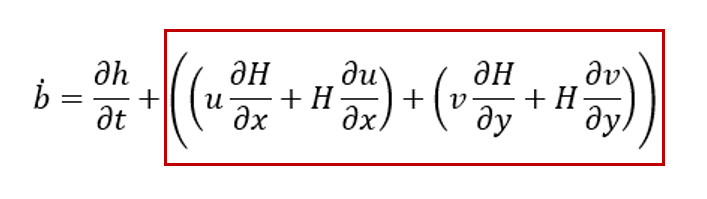

### Goals and Motivation

* This project is a piece of my           master's research, which aims to create a new, quantitative method for estimating ablation rate (mass loss over time) on the Greenland Ice Sheet. To estimate ablation rate,   I need to create estimates for all the parameters in the mass continuity equation. 

* Defining a new approach for estimating ablation rate is important because, currently, ablation models perform poorly around the Greenland Ice Sheet margins (low elevation areas), where ablation is the greatest.

* For my project, I chose to work on estimating the **_u, v, H, du/dx, dv/dy, dH/dx,_** and **_dH/dy_**       parameters because the process involves raster sampling/manipulation, which aligns with some of the topics we've covered in this class.

### Datasets
* **MEaSUREs Greenland Ice Velocity: Selected Glacier Site Velocity Maps from InSAR, Version 4**

    * These MEaSUREs datasets, downloaded from NSIDC, provides ice velocity maps (rasters) at specific areas around the Greenland Ice Sheet. The data are stored in GeoTIFF         format and contain x and y velocities, errors in the x and y velocities, and total velocity magnitude. The maps have a spatial resolution of 100 meters.
    
    
* **IceBridge BedMachine Greenland, Version 4**

    * The BedMachine v4 dataset, also downloaded from NSIDC, contains Greenland Ice Sheet wide estimates of bed topography/bathymetry, surface elevation, ice thickness, and         ice thickness error; I will be using the ice thickness and ice thickness error maps. The data are stored in NetCDF format and have a 150 meter spatial resolution.

### Workflow Expectations

* The workflow I built samples MEaSUREs and BedMachine rasters using a 500 meter buffer at a weather station near Upernavik Glacier. 

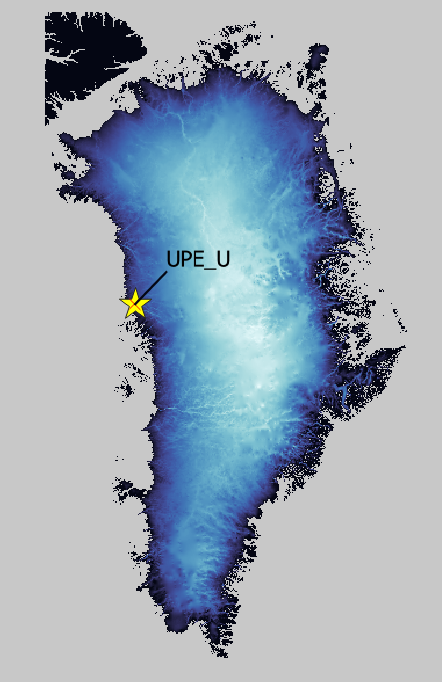

### Other Important Methods

* The velocity maps need to be downscaled to 150 meters before sampling, to match the coarser spatial resolution of BedMachine. 

* Once sampled, I will calculate the velocity and thickness gradients (du/dx, dv/dy, dH/dx, and dH/dy) with finite difference approximations. 

* To create daily estimates of **_u, v, du/dx,_** and **_dv/dy_**, I will linearly               interpolate values based on the median value of the sampled rasters for all days between sampled dates (confusing, but the plot below helps visualize!).

<img src="interp_vels.PNG" width="700" height="700" />

### Import Modules

In [25]:
import numpy as np
import pandas as pd
import geopandas as gpd

import gdal
import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.plot import show
from rasterio.transform import Affine
import netCDF4 as nc

from pathlib import Path
from dateutil import parser

### Creating Buffer Geometry, Velocity Raster Paths, and Date Objects

In [36]:
station = 'UPE_U' # Weather station name

aws_sites = gpd.read_file('AWS/Good_AWS.gpkg') # Read weather station GPKG into Geopandas
aws_location = aws_sites[aws_sites['Station_Name'] == station] # Select the Upernavik Glacier weather station

mc_circle = aws_location.buffer(500) # Generate a 500 meter buffer around the weather station location
mc_circle.to_file('AWS/'+station+'/mc_circle.gpkg', driver='GPKG') # Write the buffered circle geomeotry to a new GPKG

x_velpaths = list(Path('Velocities/'+station).glob('*vx_v*')) # Load all available MEaSUREs velocity maps by map type (x velocity, y velocity, x error, y error)
y_velpaths = list(Path('Velocities/'+station).glob('*vy_v*'))
x_err_velpaths = list(Path('Velocities/'+station).glob('*ex_v*'))
y_err_velpaths = list(Path('Velocities/'+station).glob('*ey_v*'))

vel_startdate = [parser.parse(str(x_velpaths[i])[29:36]) for i in range(len(x_velpaths))] 
vel_enddate = [parser.parse(str(x_velpaths[i])[37:44]) for i in range(len(x_velpaths))]

vel_middate = [vel_startdate[i] + (vel_enddate[i] - vel_startdate[i]) / 2 for i in range(len(x_velpaths))]

is2_dates = ['2020-06-30', '2020-09-29']

### Sampling Ice Velocities from MEaSUREs Datasets

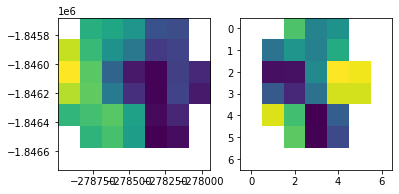

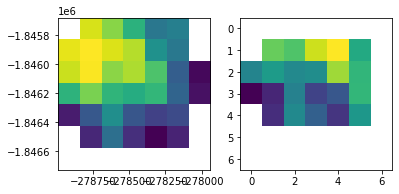

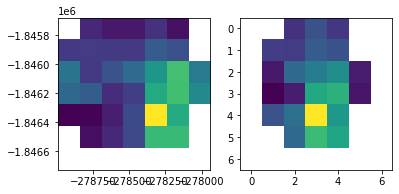

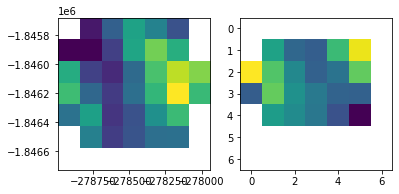

In [37]:
def vel_processing(filepaths):
    """
    Function for sampling and calculating finite differences from MEaSUREs velocity maps.
    """
    output_rasters = ['Velocities/' + station + '/' + str(filepaths[i])[29:44] + str(filepaths[i])[53:56] + '_clip.tif' for i in range(len(filepaths))]

    vel_clip = [gdal.Warp(output_rasters[i], str(filepaths[i]), cutlineDSName = 'AWS/'+station+'/mc_circle.gpkg', 
                   cropToCutline=True, xRes=150, yRes=150, format = 'GTiff', dstNodata = np.nan) for i in range(len(filepaths))]

    vel_rasts = [rio.open(output_rasters[i]).read(1) for i in range(len(output_rasters))]
    
    nan_column = np.full((vel_rasts[0].shape[0], 1), np.nan)
    nan_row = np.full((1, vel_rasts[0].shape[1]), np.nan)

    booleans = [output_rasters[i][34] == 'x' for i in range(len(output_rasters))]

    for i in range(len(booleans)):
        if booleans[i] == True:
            finite_diffs = [(vel_rasts[i][:,2:] - vel_rasts[i][:,:-2])/(2*150) for i in range(len(output_rasters))]
            finite_diffs = [np.hstack((nan_column, finite_diffs[i], nan_column)) for i in range(len(output_rasters))]

        elif booleans[i] == False:
            finite_diffs = [(vel_rasts[i][2:,:] - vel_rasts[i][:-2,:])/(2*150) for i in range(len(output_rasters))]
            finite_diffs = [np.vstack((nan_row, finite_diffs[i], nan_row)) for i in range(len(output_rasters))]

    fig, (ax1, ax2) = plt.subplots(1,2)
    [show(rio.open(output_rasters[i]), ax = ax1) for i in range(len(output_rasters))]
    [show(finite_diffs[i], ax = ax2) for i in range(len(finite_diffs))]
    
    return vel_rasts, finite_diffs

u, du_dx = vel_processing(x_velpaths)
v, dv_dy = vel_processing(y_velpaths)
u_err, du_dx_err = vel_processing(x_err_velpaths)
v_err, dv_dy_err = vel_processing(y_err_velpaths)

### Converting BedMachine v4 Dataset from NetCDF to GeoTIFF format

<AxesSubplot:>

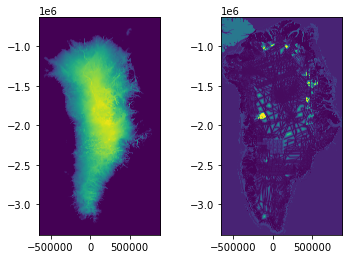

In [38]:
bedv4 = nc.Dataset('Bed_Machine/BedMachineGreenland-2021-04-20.nc')

bed_x = bedv4.variables['x'][:]
bed_y = bedv4.variables['y'][:]
bed_thickness = bedv4.variables['thickness'][:]
bed_error = bedv4.variables['errbed'][:]

res = 150
transform = Affine.translation(bed_x[0] - res/2, bed_y[0] - res/2) * Affine.scale(res, res * -1)

def netCDF_to_tif(filepath, variable):
    """
    Convert netCDF variable to GeoTiff.
    """
    tif = rio.open(
         filepath,
         mode = 'w',
         driver = 'GTiff',
         height = variable.shape[0],
         width = variable.shape[1],
         count = 1,
         dtype = variable.dtype,
         crs = 3413,
         transform = transform)

    tif.write(variable, 1)
    tif.close()
    return

netCDF_to_tif('Bed_Machine/Thickness.tif', bed_thickness)
netCDF_to_tif('Bed_Machine/Thickness_Error.tif', bed_error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,4))

show(rio.open('Bed_Machine/Thickness.tif'), ax = ax1)
show(rio.open('Bed_Machine/Thickness_Error.tif'), ax = ax2)

### Sampling Ice Thickness from New BedMachine v4 GeoTIFF

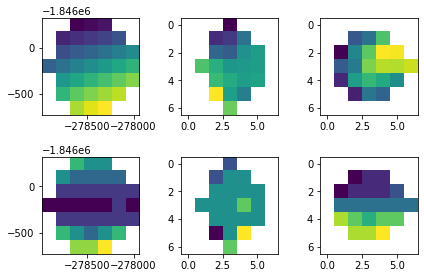

In [39]:
input_rasters = ['Bed_Machine/Thickness.tif', 'Bed_Machine/Thickness_Error.tif']
output_rasters = ['Bed_Machine/' + station + '/thickness_clip.tif', 'Bed_Machine/' + station + '/error_clip.tif']

for i in range(len(input_rasters)):
    clip = gdal.Warp(output_rasters[i], input_rasters[i], cutlineDSName = 'AWS/'+station+'/mc_circle.gpkg',
                     cropToCutline=True, xRes=150, yRes=150, format = 'GTiff', dstNodata = np.nan)

H = rio.open(output_rasters[0]).read(1)
H_err = rio.open(output_rasters[1]).read(1).astype(np.float)
H_err[H_err < 1] = np.nan

nan_column = np.full((H.shape[0], 1), np.nan)
nan_row = np.full((1, H.shape[1]), np.nan)

dh_dx = np.hstack((nan_column, (H[:,2:] - H[:,:-2])/(2*150), nan_column))
dh_dx_err = np.hstack((nan_column, (H_err[:,2:] - H_err[:,:-2])/(2*150), nan_column))

dh_dy = np.vstack((nan_row, (H[2:,:] - H[:-2,:])/(2*150), nan_row))
dh_dy_err = np.vstack((nan_row, (H_err[2:,:] - H_err[:-2,:])/(2*150), nan_row))

fig, ((ax1,ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)

show(rio.open('Bed_Machine/'+station+'/thickness_clip.tif'),ax=ax1), show(dh_dx,ax=ax2), show(dh_dy, ax=ax3) 
show(rio.open('Bed_Machine/'+station+'/error_clip.tif'),ax=ax4), show(dh_dx_err, ax=ax5), show(dh_dy_err, ax=ax6)

plt.tight_layout()

### Creating a Common Sampling Extent within the Buffered Region

#### Velocity Rasters

In [40]:
def sample_extent(velocity_array, gradient_array):
    """
    Reduce velocity and velocity gradient arrays to the overlapping extent of all parameters; done for nanmedian sampling purposes.
    """
    
    velocity = [velocity_array[i] * ( (u[i] * dh_dx + H * du_dx[i]) + (v[i] * dh_dy + H * dv_dy[i]) ) / ( (u[i] * dh_dx + H * du_dx[i]) + (v[i] * dh_dy + H * dv_dy[i]) ) 
                for i in range(len(velocity_array))]
    
    gradient = [gradient_array[i] * ( (u[i] * dh_dx + H * du_dx[i]) + (v[i] * dh_dy + H * dv_dy[i]) ) / ( (u[i] * dh_dx + H * du_dx[i]) + (v[i] * dh_dy + H * dv_dy[i]) ) 
                for i in range(len(gradient_array))]
    
    return velocity, gradient

u, du_dx = sample_extent(u, du_dx)
v, dv_dy = sample_extent(v, dv_dy)
u_err, du_dx_err = sample_extent(u_err, du_dx_err)
v_err, dv_dy_err = sample_extent(v_err, dv_dy_err)

#### Thickness Rasters

In [41]:
def thickness_extent(thickness_array):
    
    thickness = [thickness_array * (u[i]) / (u[i]) for i in range(len(u))]
    
    final_thickness = np.nanmedian([np.nanmedian(thickness[i]) for i in range(len(thickness))])
    
    return final_thickness

H = thickness_extent(H)
H_err = thickness_extent(H_err)
dh_dx = thickness_extent(dh_dx)
dh_dx_err = thickness_extent(dh_dx_err)
dh_dy = thickness_extent(dh_dy)
dh_dy_err = thickness_extent(dh_dy_err)

### Linearly Interpolating Sampled Median Velocities Over a Range of Dates

In [42]:
def vel_interp(velocity_array, gradient_array):
    
    vel_df = pd.DataFrame()
    
    vel_df['Median Velocity'] = [np.nanmedian(velocity_array[i]) for i in range(len(velocity_array))]
    vel_df['Median Gradient'] = [np.nanmedian(gradient_array[i]) for i in range(len(gradient_array))]
    
    vel_df['Mid-Date'] = vel_middate
    vel_df.sort_values('Mid-Date', inplace = True)
    vel_df.set_index('Mid-Date',inplace = True)

    vel_df = vel_df.reindex(pd.date_range(start = vel_df.index.min(), end = vel_df.index.max(), freq = '1D'))

    vel_df['Median Velocity'] = vel_df['Median Velocity'].interpolate(method='linear') 
    vel_df['Median Gradient'] = vel_df['Median Gradient'].interpolate(method='linear') 

    velocity = np.nanmedian(vel_df.loc[is2_dates[0] : is2_dates[1]]['Median Velocity'])
    gradient = np.nanmedian(vel_df.loc[is2_dates[0] : is2_dates[1]]['Median Gradient'])
    
    return velocity, gradient

u, du_dx = vel_interp(u, du_dx)
v, dv_dy = vel_interp(v, dv_dy)
u_err, du_dx_err = vel_interp(u_err, du_dx_err)
v_err, dv_dy_err = vel_interp(v_err, dv_dy_err)

## Back to the Mass Continuity Equation


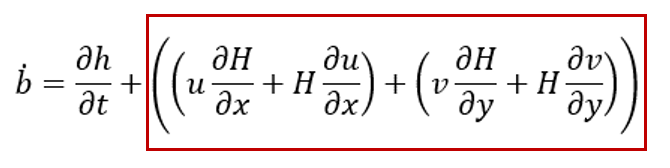

### Individual Components

In [61]:
print('The x-velocity (u) is', np.round(u, 2), 'm/yr')
print('The y-velocity (v) is', np.round(v, 2), 'm/yr')
print ("\n")

print('The x-velocity gradient (du/dx) is', np.round(du_dx, 3), '1/yr')
print('The y-velocity gradient (dv/dy) is', np.round(dv_dy, 3), '1/yr')
print ("\n")

print('The ice thickness (H) is', np.round(H, 2), 'm')
print ("\n")

print('The ice thickness x-gradient (dh/dx) is', np.round(dh_dx, 2))
print('The ice thickness y-gradient (dh/dy) is', np.round(dh_dy, 2))

The x-velocity (u) is -188.39 m/yr
The y-velocity (v) is -24.99 m/yr


The x-velocity gradient (du/dx) is -0.018 1/yr
The y-velocity gradient (dv/dy) is -0.011 1/yr


The ice thickness (H) is 605.8 m


The ice thickness x-gradient (dh/dx) is 0.02
The ice thickness y-gradient (dh/dy) is 0.07


### The Total (Ice Flux Divergence)

In [63]:
print('The ice flux divergence at the sampled location is', np.round(  (  ((u * dh_dx) + (H * du_dx)) + ((v * dh_dy) + (H * dv_dy))  ), 2) , 'm/yr')

The ice flux divergence at the sampled location is -23.56 m/yr


## Conclusions

* At the location I sampled, within the buffered circle, the ice is thinning at a rate of **23.56 m/yr** between **June 30, 2020** and **September 29, 2020**! 

* This thinning is ONLY derived from the dynamic (mechanical) motion of the ice, within the buffered region! 

* Next step, calculate **dh/dt**, the surface elevation thinning rate, with **ICESat-2** laser altimetry!